In [5]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from file_paths_and_consts import *
import os
import geopandas as gpd
import pandas as pd
import json
import sys
import argparse
import warnings
import pickle
import properscoring as ps
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from skopt import Optimizer
import sys
from surrogate_utils import *

warnings.filterwarnings('ignore')
    
geo_shp_file = BASE_DIR+'raw_data/UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'
ukr_gdf = gpd.read_file(geo_shp_file)
all_raions = ukr_gdf['ADM2_EN'].tolist()
print('regions read..',flush=True)

raion_to_dest_df = pd.read_csv('from_raion_to_dest_refugee_pdf.csv')

## reading ground truth data

## poland gt data
pl_border_data = pd.read_csv('poland_border_movement_utf8.csv',thousands=',')
#ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset=['Total'])
pl_border_data['Date'] = pd.to_datetime(pl_border_data['Date'])
ukr_people_arrive_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Arrival to Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.sort_values(by='Date')
ukr_people_depart_poland_by_date = ((pl_border_data[(pl_border_data.Direction=='Departure from Poland') & (pl_border_data['Citizenship (Code)']=='UA')]).groupby('Date')['Total'].sum()).reset_index()
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.sort_values(by='Date')
ukr_people_arrive_poland_by_date['Total'] = ukr_people_arrive_poland_by_date['Total'].rolling(15).mean()
ukr_people_depart_poland_by_date['Total'] = ukr_people_depart_poland_by_date['Total'].rolling(15).mean()
ukr_people_arrive_poland_by_date = ukr_people_arrive_poland_by_date.dropna(subset='Total')
ukr_people_depart_poland_by_date = ukr_people_depart_poland_by_date.dropna(subset='Total')
ukr_people_arrive_poland_by_date =  ukr_people_arrive_poland_by_date.rename(columns={'Date':'return_date','Total':'arrival'})
ukr_people_depart_poland_by_date =  ukr_people_depart_poland_by_date.rename(columns={'Date':'return_date','Total':'departure'})

intention_sim_demo4 = load_intention_destination_df_by_demo_category4(raion_to_dest_df,all_raions)
#intention_sim = load_intention_destination_df(raion_to_dest_df,all_raions)

regions read..
5
6
7
9
11
12
14
19
21
23
26
29
39
40
43
45
46
48
49
50
51
53
54
63
67
78
86
87
98


In [2]:
# ratios = [[],[],[],[]]

# for df in intention_sim_demo4:
#     mm = df['male_only'].sum()/df['h_size'].sum()
#     ff = df['female_only'].sum()/df['h_size'].sum()
#     cc = df['just_couples'].sum()/df['h_size'].sum()
#     vv = df['elderly_and_or_child'].sum()/df['h_size'].sum()
    
#     ratios[0].append(mm)
#     ratios[1].append(ff)
#     ratios[2].append(cc)
#     ratios[3].append(vv)

# for i in range(4):
#     print(np.mean(np.array(ratios[i]))*100.00,np.std(np.array(ratios[i]))*100.00)

In [6]:
import ast

random_state = 4
lerror = 0.5
lcorr = 0.05

roll = 7
lag = 35

conflict_context = get_conflict_data(roll,lag)

opt = Optimizer([(0.0, 0.0009),(0.0, 0.0009),(0.0, 0.0009), (0.0, 0.0009)], 
                "GP", acq_func="EI",acq_optimizer="sampling",random_state=random_state)

optimizer_name = f'return-optimizer-bayes-demo4-surrrogate-const-{random_state}'
fname = 'slurm-1811658.out'

p = f'slurm-{1811658+random_state}.out'
data = []
with open(p,"r") as f:
    for i in f.readlines():
        if i.startswith('['):
            data.append(ast.literal_eval(i.strip()))
#data = np.array(data)
#print(data)
#print(type(data))    


In [25]:
x_star = [0.0008572837442908861, 0.0002763449185189221, 0.00026894121233845544, 0.00028504189363068294]

ll,nrmse,corr,crps,f_x = estimate_blackbox_function_loss_per_demo4(intention_sim_demo4,ukr_people_depart_poland_by_date,
                                                           surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,no_print=1,conflict_context=conflict_context)

print(nrmse,corr)

0.13576077980168522 0.9104908177685801


In [11]:
np.arange(0.0001,0.002,0.0001)

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019])

0.0002 0.13867189955394865 0.9173836542905288
0.00021 0.13803484148307188 0.9165424529319315
0.00022 0.137483971485442 0.9156844313785454
0.00023 0.13701379898966726 0.914816018372128
0.00024 0.13662172138241982 0.9139217744862386
0.00025 0.13630175478728956 0.9130049283903438
0.00026 0.13604476742786642 0.9120702979654358
0.00027 0.135852072037234 0.9111111388644654
0.00028 0.13571776276977854 0.9101310867694784
0.00029 0.1356343096302519 0.9091332601130484
0.0003 0.1355964026523181 0.908122499554548
0.00031 0.13560060838421906 0.9071029194857609
0.00032 0.13564087558433513 0.9060797065676109
0.00033 0.135708155125419 0.9050671514020183
0.00034 0.13580566963342947 0.9040573573585996
0.00035 0.13593311820626294 0.9030447905482658
0.00036 0.13608981098803086 0.9020251124174332
0.00037 0.1362690390523789 0.9010069441233529
0.00038 0.1364685400159451 0.8999917267914916
0.00039 0.1366822438748809 0.8989891139920231
0.0002 0.1976579251836608 0.943266129190113
0.00021 0.18192982927593632 0.9

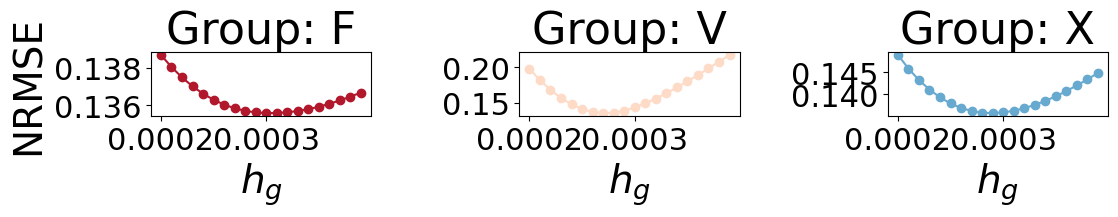

In [44]:
import matplotlib.pyplot as plt

from matplotlib import rcParams

max_font_size = 34
rcParams["font.size"] = max_font_size
rcParams["axes.labelsize"] = max_font_size-6
rcParams["axes.titlesize"] = max_font_size-6
rcParams["xtick.labelsize"] = max_font_size-12
rcParams["ytick.labelsize"] = max_font_size-12

fig,ax = plt.subplots(1,3,figsize=(12,3))


groups = ['F','V','X']
colors = ['#b2182b','#fddbc7','#67a9cf']


for i in range(1,4):
    x_star = [0.0008572837442908861, 0.0002763449185189221, 0.00026894121233845544, 0.00028504189363068294]
    xs = []
    errs = []
    pccs = []
    for x in np.arange(0.0002,0.0004,0.00001):
        x_star[i] = x
        ll,nrmse,corr,crps,f_x = estimate_blackbox_function_loss_per_demo4(intention_sim_demo4,ukr_people_depart_poland_by_date,
                                                               surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,no_print=1,conflict_context=conflict_context)
        xs.append(x)
        errs.append(nrmse)
        pccs.append(corr)
        print(round(x,5),nrmse,corr)
    
    ax[i-1].plot(xs,errs,label='Err',marker='o',color=colors[i-1])
    ax[i-1].set_xlabel('$h_g$',fontsize=28)
    if i==1:
        ax[i-1].set_ylabel('NRMSE',fontsize=28)
    ax[i-1].set_title(f'Group: {groups[i-1]}',fontsize=32)
    #ax2 = ax[i-1].twinx()
    #ax2.plot(xs,pccs,label='PCC',marker='P')

fig.tight_layout()

In [9]:
def compute_covariance(sim_df, observed_df, observe_col, date_start, date_end,lerror=0.8, lcorr=0.2, date_col='return_date',gt_scale=1.0,print_flag=1):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    return merged_df[observe_col].cov(merged_df['returnee'])

def compute_std(sim_df, observed_df, observe_col, date_start, date_end,lerror=0.8, lcorr=0.2, date_col='return_date',gt_scale=1.0,print_flag=1):
    merged_df = sim_df.merge(observed_df,on=date_col,how='inner')
    merged_df = merged_df[(merged_df[date_col]>=pd.to_datetime(date_start)) & (merged_df[date_col]<=pd.to_datetime(date_end))]
    merged_df[observe_col] = merged_df[observe_col]/gt_scale
    return merged_df['returnee'].std()

In [ ]:
x_star = [0.0002]
ll,nrmse,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                      surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                      no_print=1,conflict_context=conflict_context)

cov1 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                         print_flag=0)
print(cov)

std1 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                         print_flag=0)
print(std)

x_star = [0.00021]
ll,nrmse,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                      surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                      no_print=1,conflict_context=conflict_context)

cov2 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                         print_flag=0)
print(cov)

std2 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                         print_flag=0)
print(std)

grad_cov1 = (cov1-cov2)/(0.0002-0.00021)
grad_std1 = (std1-std2)/(0.0002-0.00021)

lhs = grad_cov1/cov1
rhs = grad_std1/std1

print(lhs,rhs)


In [26]:
np.arange(0.0001,0.001,0.00005)

array([0.0001 , 0.00015, 0.0002 , 0.00025, 0.0003 , 0.00035, 0.0004 ,
       0.00045, 0.0005 , 0.00055, 0.0006 , 0.00065, 0.0007 , 0.00075,
       0.0008 , 0.00085, 0.0009 , 0.00095])

In [34]:
delta = 0.00000001

all_dicts = []

for xs in np.arange(0.0002765,0.0002775,0.0000001):
    x_star = [xs]
    ll,nrmse1,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                          surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                          no_print=1,conflict_context=conflict_context)

    cov1 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(cov)

    std1 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(std)

    x_star = [xs+delta]
    ll,nrmse2,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                          surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                          no_print=1,conflict_context=conflict_context)

    cov2 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(cov)

    std2 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(std)

    grad_cov1 = (cov1-cov2)/(-delta)
    grad_std1 = (std1-std2)/(-delta)

    lhs = grad_cov1/cov1
    rhs = grad_std1/std1

    print(round(xs,7),lhs,rhs,(nrmse1-nrmse2)/(-delta))
    all_dicts.append({'$\\theta$':xs,'$\\frac{\\nabla \sigma_{f, \\hat{R}}}{\\sigma_{f,\hat{R}}}$':lhs,
                     '$\\frac{\\nabla \sigma_f}{\sigma_f}$':rhs,'$\\nabla RMSE(\\theta)$':(nrmse1-nrmse2)/(-delta)})
    
around_loc_min = pd.DataFrame.from_dict(all_dicts)

0.0002765 -4095.0297391708245 -1979.413277633593 -17.83132830834866
0.0002766 -4098.525636114859 -1976.5447459381091 -13.966555914568524
0.0002767 -4102.023035381989 -1973.670578480364 -10.105441525243286
0.0002768 -4105.521993627312 -1970.790819656766 -6.248004696951526
0.0002769 -4109.02241455477 -1967.9053942409648 -2.3942861748782462
0.000277 -4112.52443672288 -1965.0144194069128 1.4556988614522481
0.0002771 -4107.421301841447 -1941.8696705657635 6.584413908550246
0.0002772 -4151.437527841684 -1986.6011210644238 18.054936753997275
0.0002773 -4154.970179750139 -1983.640919788741 21.890978962879615
0.0002774 -4158.504449937135 -1980.6750170023765 25.72312268467325
0.0002775 -4162.040292599788 -1977.703386043719 29.55133452109404


In [26]:
delta = 0.00000001

all_dicts = []

for xs in np.arange(0.0001,0.001,0.00005):
    x_star = [xs]
    ll,nrmse1,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                          surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                          no_print=1,conflict_context=conflict_context)

    cov1 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(cov)

    std1 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(std)

    x_star = [xs+delta]
    ll,nrmse2,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                          surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                          no_print=1,conflict_context=conflict_context)

    cov2 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(cov)

    std2 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(std)

    grad_cov1 = (cov1-cov2)/(-delta)
    grad_std1 = (std1-std2)/(-delta)

    lhs = grad_cov1/cov1
    rhs = grad_std1/std1

    print(round(xs,7),lhs,rhs,(nrmse1-nrmse2)/(-delta))
    all_dicts.append({'$\\theta$':round(xs,7),'$\\frac{\\nabla \sigma_{f, \\hat{R}}}{\\sigma_{f,\hat{R}}}$':lhs,
                     '$\\frac{\\nabla \sigma_f}{\sigma_f}$':rhs,'$\\nabla RMSE(\\theta)$':(nrmse1-nrmse2)/(-delta)})
    
overall = pd.DataFrame.from_dict(all_dicts)

0.0001 4364.290874228776 2908.489304411506 -5088.988559531771
0.00015 793.349641866539 -384.2760866996443 -3685.474779929754
0.0002 -1362.7762940553077 -2090.909702256894 -2566.1565254270213
0.00025 -3180.140218053641 -2453.694802998954 -1086.638761607639
0.0003 -4980.408036783411 -1341.1704060188233 707.5862925004506
0.00035 -7602.458343771509 486.0040140208146 1302.2476356677748
0.0004 -13579.183999764045 2092.404580995422 1375.0022766101376
0.00045 -41855.27309031125 2644.295102533105 1271.5651009520545
0.0005 38370.934345798596 2489.9756937682673 1135.9667186627842
0.00055 12872.496545078 2309.491283073254 1035.7449393594286
0.0006 7438.6535180149895 2060.997093809742 937.9260593023187
0.00065 5139.107267662711 1828.3335217585513 857.0310376154744
0.0007 3835.1511314321274 1581.3971865662072 772.5405049452405
0.00075 3022.061252015815 1379.7768695935179 703.1521820910491
0.0008 2431.3182764614453 1192.2738249157335 632.4074083630115
0.00085 2015.3892181897102 1043.4857370087716 573

In [35]:
around_loc_min

,$\theta$,"$\frac{\nabla \sigma_{f, \hat{R}}}{\sigma_{f,\hat{R}}}$",$\frac{\nabla \sigma_f}{\sigma_f}$,$\nabla RMSE(\theta)$
0,0.000276,-4095.029739,-1979.413278,-17.831328
1,0.000277,-4098.525636,-1976.544746,-13.966556
2,0.000277,-4102.023035,-1973.670578,-10.105442
3,0.000277,-4105.521994,-1970.790820,-6.248005
4,0.000277,-4109.022415,-1967.905394,-2.394286
5,0.000277,-4112.524437,-1965.014419,1.455699
6,0.000277,-4107.421302,-1941.869671,6.584414
7,0.000277,-4151.437528,-1986.601121,18.054937
8,0.000277,-4154.970180,-1983.640920,21.890979
9,0.000277,-4158.504450,-1980.675017,25.723123


In [32]:
print(around_loc_min.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
$\theta$ & $\frac{\nabla \sigma_{f, \hat{R}}}{\sigma_{f,\hat{R}}}$ & $\frac{\nabla \sigma_f}{\sigma_f}$ & $\nabla RMSE(\theta)$ \\
\midrule
0.000276 & -4095.029739 & -1979.413278 & -17.831328 \\
0.000277 & -4098.525636 & -1976.544746 & -13.966556 \\
0.000277 & -4102.023035 & -1973.670578 & -10.105442 \\
0.000277 & -4105.521994 & -1970.790820 & -6.248005 \\
0.000277 & -4109.022415 & -1967.905394 & -2.394286 \\
0.000277 & -4112.524437 & -1965.014419 & 1.455699 \\
0.000277 & -4107.421302 & -1941.869671 & 6.584414 \\
0.000277 & -4151.437528 & -1986.601121 & 18.054937 \\
0.000277 & -4154.970180 & -1983.640920 & 21.890979 \\
0.000277 & -4158.504450 & -1980.675017 & 25.723123 \\
0.000278 & -4162.040293 & -1977.703386 & 29.551335 \\
\bottomrule
\end{tabular}



In [23]:
delta = 0.00000001
for xs in np.arange(0.0001,0.001,0.0001):
    x_star = [xs]
    ll,nrmse,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                          surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                          no_print=1,conflict_context=conflict_context)

    cov1 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(cov)

    std1 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(std)

    x_star = [xs+delta]
    ll,nrmse,corr,crps,f_x = estimate_blackbox_function_loss(intention_sim,ukr_people_depart_poland_by_date,
                                                          surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,
                                                          no_print=1,conflict_context=conflict_context)

    cov2 = compute_covariance(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(cov)

    std2 = compute_std(f_x, ukr_people_depart_poland_by_date, 'departure', '2022-04-01', '2022-08-01',
                             print_flag=0)
    #print(std)

    grad_cov1 = (cov1-cov2)/(-delta)
    grad_std1 = (std1-std2)/(-delta)

    lhs = grad_cov1/cov1
    rhs = grad_std1/std1

    print(round(xs,4),lhs,rhs)


0.0001 4364.290874228776 2908.489304411506
0.0002 -1362.7762940553077 -2090.909702256894
0.0003 -4980.408036783411 -1341.1704060188233
0.0004 -13579.183999764045 2092.404580995422
0.0005 38370.934345798596 2489.9756937682673
0.0006 7438.6535180149895 2060.997093809742
0.0007 3835.1511314321274 1581.3971865662072
0.0008 2431.3182764614453 1192.2738249157335
0.0009 1707.8858604799284 933.6093969764858


In [8]:
f_x

,return_date,returnee,q1,q3
0,2022-02-24,0.000000,0.000000,0.000000
1,2022-02-25,4.395000,3.314400,5.880520
2,2022-02-26,30.474992,25.335922,38.192489
3,2022-02-27,71.636163,62.683538,90.030594
4,2022-02-28,131.864306,113.438138,163.344405
...,...,...,...,...
187,2022-08-30,16289.349341,13581.700571,18159.440169
188,2022-08-31,16178.628270,13446.324843,17978.981746
189,2022-09-01,16063.406745,13308.164517,17795.057941
190,2022-09-09,15955.185849,13175.388951,17618.466545


In [16]:
print(nrmse,corr)

0.13576077980168522 0.9104908177685801


In [24]:
x_star = [0.0005, 0.0003, 0.0002, 0.0003]

ll,nrmse,corr,crps,_ = estimate_blackbox_function_loss_per_demo4(intention_sim_demo4,ukr_people_depart_poland_by_date,
                                                           surrogate_conflict_haz,x_star,lerr=lerror,lcorr=lcorr,no_print=1,conflict_context=conflict_context)

In [25]:
print(nrmse,corr)

0.19294964830659642 0.9441709082072338


In [28]:
len(data)

1000

In [29]:
tot_it = 1000
yy = []
import time
st = time.time()
for x in data:
    if tot_it%50==0:
        print('50 iteration done in',round(time.time()-st,4),'seconds')
        st = time.time()
        print(tot_it)
    tot_it = tot_it-1
    #if(i%10==0):
    #    print(i,'saving optimizer...',flush=True)
        #with open(f'../optimizers/{optimizer_name}', 'wb') as f:
        #    pickle.dump(opt, f)
    #rr = opt.ask()
    #print(rr)
    ll,_,_,_,_ = estimate_blackbox_function_loss_per_demo4(intention_sim_demo4,ukr_people_depart_poland_by_date,
                                                           surrogate_conflict_haz,x,lerr=lerror,lcorr=lcorr,no_print=1,conflict_context=conflict_context)
    #print(next_h,ll)
    #opt.tell(x,ll)
    yy.append(ll)
    

#print(f'best result after {tot_it} iteration has a loss of',opt.get_result()['fun'],'for',opt.get_result()['x'])
#_,nrmse,corr,_,_ = estimate_blackbox_function_loss_per_demo4(intention_sim_demo4,ukr_people_depart_poland_by_date,
#                                                          surrogate_conflict_haz,opt.get_result()['x'],lerr=lerror,lcorr=lcorr,no_print=1,
#                                                            conflict_context=conflict_context)
#print('nrmse:',nrmse)
#print('corr:',corr)

#ll_const,sim_df_const = estimate_blackbox_function_loss(intention_sim,surrogate_constant_haz,opt.get_result()['x'],no_print=0)

#with open(f'../optimizers/{optimizer_name}', 'wb') as f:
#    pickle.dump(opt, f)
    
#groups = ['single_male','single_female','male_only','female_only',
#              'elderly_no_child','child_no_elderly','child_and_elderly','just_couples']

50 iteration done in 0.0001 seconds
1000
50 iteration done in 30.9212 seconds
950
50 iteration done in 30.9594 seconds
900
50 iteration done in 31.2456 seconds
850
50 iteration done in 31.3154 seconds
800
50 iteration done in 31.1787 seconds
750
50 iteration done in 31.2938 seconds
700
50 iteration done in 31.408 seconds
650
50 iteration done in 31.2194 seconds
600
50 iteration done in 31.1493 seconds
550
50 iteration done in 31.2584 seconds
500
50 iteration done in 32.1721 seconds
450
50 iteration done in 32.493 seconds
400
50 iteration done in 31.8652 seconds
350
50 iteration done in 31.8144 seconds
300
50 iteration done in 31.7284 seconds
250
50 iteration done in 32.0462 seconds
200
50 iteration done in 31.5914 seconds
150
50 iteration done in 31.2633 seconds
100
50 iteration done in 31.5435 seconds
50


In [30]:
with open(f'./surrogate_case_study_results/return-optimizer-bayes-demo4-surrrogate-const-{random_state}-x', 'wb') as f:
    np.save(f,np.array(data))
    
with open(f'./surrogate_case_study_results/return-optimizer-bayes-demo4-surrrogate-const-{random_state}-y', 'wb') as f:
    np.save(f,np.array(yy))

In [13]:
#np.array(yy).shape

(1000,)